# Implementation of model with fully open ICVs
Ashish Bhattarai and Bernt Lie
University of South-Eastern Norway
Porsgrunn, May 2021

Packages

In [1]:
using Plots
using DifferentialEquations
using LaTeXStrings
pyplot();
using SparseArrays
using StaticArrays

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1317


In [ ]:
LW1 = 2.5;
LCoil = :darkred;
LCwater = :blue;
# Plotting befor and after together
figpath = "D:/USN/Asis/MS_Thesis/USN-MSc-Lyx-Template/fig/"

In [3]:
################Constants########
g = 9.81;   #acceleration due to gravity
d2s = 86400.0;  #Factor to convert day to seconds

#Reservoir dimension
R = 200;  #in meters
L = 1200;  #in meters

#curve fitting parameters obtained from saturation and permeability data
fit1 = 3.4830677845851046;
fit2 = 0.00043971820694883656;
fit3 = 3.5326302833873475;
fit4 = 2.6282606178861068;

###########Grid size#############
m = 20; #number of grids along R
n = 20; #number of grids along L
Delr = R/m;   #step length along R
Dell = L/n;   #step length along L

##########Fluid properties########
rhoo = 950.0;  #Density of oil
rhow = 1050.0; #Density of water
uo = 100e-3;    #Oil viscosity
uw = 1e-3;   #Water viscosity

#######Rock properties##########
K_R = 1.0*1.4803849e-12;   #Absolue permability of rock along r
K_L = 1.0*1.4803849e-12;   #Absolue permability of rock along l
K_eff = sqrt(K_R*K_L);  #Effective permeability
alpha = 20*pi/180;      #Inclination angle of a wedge shaped reservoir
beta = 25*pi/180;    #arch angle of a wedge shaped reservoir
theta = alpha + beta/2;
phi = 0.27;   #rock porosity

##########Aquifier properties##########
Kwa = 1.0;    #Relative permeability of aquifer
P_a = 115e5;  # Aquifier pressure

##########Well properties#############
rw = 0.124/2.0;  #Well radius
re = 0.5*Delr;    #equivalent radius
Lw = 1200;   #Well length
Del_Lp = Dell;   #pipe step length
Nv = n;  #Number of valves
Qtot = 0.00925926;    #total specified flow rate
Ar = pi*0.003217^2/4.0;  #Orifice are

##########Array allocation for pentadiagonal matrix and other matrices##########
B_sparse = sparse(zeros(Float64, m*n,m*n));  #Column vector of size m*n, used sparse matrix to speed up the simulation
A_sparse = sparse(zeros(Float64, m*n,m*n));  #pentadiagonal matrix of dimension m*n x m*n, used sparse matrix to speed up the simulation
v = zeros(Float64, m*n);       #column vector of size m*n
P = zeros(Float64, m*n);       #matrix of dimension m x n for pressure at each block

############Arrays to store fluid flow rates,combined density and well pressure#########
qmix = zeros(Float64,n,1);
q_w = zeros(Float64,n,1);  #Water flow rate
prw = zeros(Float64,n,1);     #initialize for well pressure
rho_mix = zeros(Float64,n,1);

# Function to calculate permeability and to update water saturation

In [ ]:
function UpdatePerm(Sat)
    Perm_w = zeros(Float64, m,n);
    Perm_o = zeros(Float64, m,n);
    for i = 1:1:m
        for j = 1:1:n
            if Sat[i,j] >= 1.0
                Sat[i,j] = 1.0;
                Perm_w[i,j] = 1.0;
                Perm_o[i,j] = 0.0;
            elseif Sat[i,j] > 0.0;
                Perm_w[i,j] = Sat[i,j]^fit1 + fit2;
                Perm_o[i,j] = (1.0 -Sat[i,j])^fit3 * (1.0 -Sat[i,j]^fit4);
            else
                Sat[i,j] = 0.0;
                Perm_w[i,j] = 0.0;
                Perm_o[i,j] = 1.0;
            end
        end
    end
    return [Sat,Perm_w,Perm_o];
end

# Function to calcuate fluid flow distribution at the well

In [ ]:
function Borehole(prw,Qtot,Ax,rhomix)
    Area = zeros(Nv,1);
    Area[1:Nv] .= Ax;
    Q = zeros(Nv+1,1);
    pbh = zeros(Nv+1,1);
    pbh_limit = 85e5;
    Q[1] = Qtot
    rp = 0.124;
    Cv = 1.0;
    Cu = 1.0;
    q = zeros(Nv,1);
    fr = 0.00001;
    a = Qtot/Nv;
    b = -a^2 *(Cu*mean(rhomix))/(Cv^2*(mean(Area))^2) + mean(prw[1:Nv]);
    pbh[1] = b - fr*mean(rhomix)*8*Del_Lp/(pi^2*(2*rp)^5)*Qtot;
    if pbh[1] > pbh_limit
        pbh[1] = pbh_limit;
    end
    for i = 1:Nv
        pbh[i+1]=pbh[i]+fr*rhomix[i]*8*Del_Lp/(pi^2*(2*rp)^5)*Q[i];
        if (prw[i]-pbh[i+1])<0.0
            break;
        end
        q[i]=sqrt((prw[i]-pbh[i+1])*Cv^2*Area[i]^2/(Cu*rhomix[i]));
        Q[i+1] = Q[i] - q[i];
        if Q[i+1] <=0.0
            break;
        end
    end
    return [q,pbh[1]];
end

# Function to calculate pressure equation

In [ ]:
function PressureCalc(Krw,Kro,qmix)
    f = zeros(Float64, m*n);       #column vector of size m*n
    #For blocks at i = 1 and j = 1
    i = 1;
    j = 1;
    z = n*(i-1)+j;
    r = R + (0.5-i)*Delr;
    ri = R;
    ro = R - i*Delr;
    T_a = (Kwa/uw)*K_eff;
    T_i1j = (Kro[i,j+1]/uo + Krw[i,j+1]/uw)*K_eff;
    T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
    E_a = (Kwa*rhow/uw)*K_eff;
    E_ij = (Kro[i,j]*rhoo/uo + Krw[i,j]*rhow/uw)*K_eff;
    A_sparse[z,z] = -(1/(r*Delr^2))*(T_a*ri+T_ij*ro)-(1/Dell^2)*T_i1j;
    A_sparse[z,z+1] = (1/Dell^2)*T_i1j;
    A_sparse[z,z+n] = (1/(r*Delr^2))*ro*T_ij;
    f[1] = -(1/(r*Delr^2))*T_a*ri*P_a - (1/(r*Delr))*( E_ij*ro - E_a*ri)*g*sin(theta);
    #For blocks at i = 1 and j = 2:n-1
    i = 1;
    for j = 2:1:n-1
        z = n*(i-1)+j;
        T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
        T_i1j = (Kro[i,j+1]/uo + Krw[i,j+1]/uw)*K_eff;
        E_ij = (Kro[i,j]*rhoo/uo + Krw[i,j]*rhow/uw)*K_eff;
        A_sparse[z,z-1] = (1/(Dell^2))*T_ij;
        A_sparse[z,z] = -(1/(r*Delr^2))*(T_a*ri+T_ij*ro)-(1/Dell^2)*(T_ij + T_i1j);
        A_sparse[z,z+1] = (1/Dell^2)*T_i1j;
        A_sparse[z,z+n] = (1/(r * Delr^2))*T_ij*ro;
        f[z] = -(1/(r*Delr^2))*T_a*ri*P_a - (1/(r*Delr))*(E_ij*ro - E_a*ri)*g*sin(theta);
    end
    #For blocks at i = 1 and j = n
    i = 1;
    j = n;
    z = n*(i-1)+j;
    T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
    E_ij = (Kro[i,j]*rhoo/uo + Krw[i,j]*rhow/uw)*K_eff;
    A_sparse[z,z-1] = (1/Dell^2)*T_ij;
    A_sparse[z,z] = -(1/(r*Delr^2))*(T_a*ri+T_ij*ro)-(1/Dell^2)*T_ij;
    A_sparse[z,z+n] = (1/(r*Delr^2))*T_ij*ro;
    f[z] = -(1/(r*Delr^2))*T_a*ri*P_a - (1/(r*Delr))*(E_ij*ro - E_a*ri)*g*sin(theta);
    
    #For blocks at i = 2(m-1) and j = 2:(n-1)
    for i = 2:1:m-1
        r = R + (0.5-i)*Delr;
        ri = r + 0.5*Delr;
        ro = r - 0.5*Delr;
        for j = 2:1:n-1
            z = n*(i-1)+j;
            T_ij1 = (Kro[i-1,j]/uo + Krw[i-1,j]/uw)*K_eff;
            T_i1j = (Kro[i,j+1]/uo + Krw[i,j+1]/uw)*K_eff;
            T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
            E_ij = (Kro[i,j]*rhoo/uo + Krw[i,j]*rhow/uw)*K_eff;
            E_ij1 = (Kro[i-1,j]*rhoo/uo + Krw[i-1,j]*rhow/uw)*K_eff;
            A_sparse[z,z-n] = (1/(r*Delr^2))*T_ij1*ri;
            A_sparse[z,z-1] = (1/Dell^2)*T_ij;
            A_sparse[z,z] = -(1/(r*Delr^2))*(T_ij1*ri+T_ij*ro)-(1/Dell^2)*(T_i1j+T_ij);
            A_sparse[z,z+1] = (1/Dell^2)*T_i1j;
            A_sparse[z,z+n] = (1/(r*Delr^2))*T_ij*ro;
            f[z] = -(1/(r*Delr))*( E_ij*ro - E_ij1*ri)*g*sin(theta);
        end
        #For blocks at j = 1 and i = 2:m-1
        j = 1;
        z = n*(i-1)+j;
        T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
        T_i1j = (Kro[i,j+1]/uo + Krw[i,j+1]/uw)*K_eff;
        T_ij1 = (Kro[i-1,j]/uo + Krw[i-1,j]/uw)*K_eff;
        E_ij1 = (Kro[i-1,j]*rhoo/uo + Krw[i-1,j]*rhow/uw)*K_eff;
        E_ij = (Kro[i,j]*rhoo/uo + Krw[i,j]*rhow/uw)*K_eff;
        A_sparse[z,z-n] = (1/(r*Delr^2))*T_ij1*ri;
        A_sparse[z,z] = -(1/(r*Delr^2))*(T_ij1*ri+T_ij*ro)-(1/Dell^2)*T_i1j;
        A_sparse[z,z+1] = (1/Dell^2)*T_i1j;
        A_sparse[z,z+n] = (1/(r*Delr^2))*T_ij*ro;
        f[z] = -(1/(r*Delr))*(E_ij*ro - E_ij1*ri)*g*sin(theta);
        #For blocks at j = n and i = 2:m-1
        j = n;
        z = n*(i-1)+j;
        T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
        T_ij1 = (Kro[i-1,j]/uo + Krw[i-1,j]/uw)*K_eff;
        E_ij1 = (Kro[i-1,j]*rhoo/uo + Krw[i-1,j]*rhow/uw)*K_eff;
        E_ij = (Kro[i,j]*rhoo/uo + Krw[i,j]*rhow/uw)*K_eff;
        A_sparse[z,z-n] = (1/(r*Delr^2))*T_ij1*ri;
        A_sparse[z,z-1] = (1/Dell^2)*T_ij;
        A_sparse[z,z] = -(1/(r*Delr^2))*(T_ij1*ri+T_ij*ro)-(1/Dell^2)*T_ij;
        A_sparse[z,z+n] = (1/(r*Delr^2))*T_ij*ro;
        f[z] = -(1/(r*Delr))*(E_ij*ro - E_ij1*ri)*g*sin(theta);
    end
    
    #For blocks at i = m and j = 1
    i = m;
    j = 1;
    z = n*(i-1)+j;
    r = R + (0.5-i)*Delr;
    ri = r + 0.5*Delr;
    ro = r - 0.5*Delr;
    T_ij1 = (Kro[i-1,j]/uo + Krw[i-1,j]/uw)*K_eff;
    T_i1j = (Kro[i,j+1]/uo + Krw[i,j+1]/uw)*K_eff;
    E_ij1 = (Kro[i-1,j]*rhoo/uo + Krw[i-1,j]*rhow/uw)*K_eff;
    A_sparse[z,z-n] = (1/(r*Delr^2))*ri*T_ij1;
    A_sparse[z,z] = -(1/(r*Delr^2))*T_ij1*ri-(1/Dell^2)*T_i1j;
    A_sparse[z,z+1] = (1/Dell^2)*T_i1j;
    f[z] = qmix[j]/(beta*r*Dell*Delr) + (1/(r*Delr))*E_ij1*ri*g*sin(theta);
    #For blocks at i = m and j = n
    j = n;
    z = n*(i-1)+j;
    T_ij1 = (Kro[i-1,j]/uo + Krw[i-1,j]/uw)*K_eff;
    T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
    E_ij1 = (Kro[i-1,j]*rhoo/uo + Krw[i-1,j]*rhow/uw)*K_eff;
    A_sparse[z,z-n] = (1/(r*Delr^2))*(ri*T_ij1);
    A_sparse[z,z-1] = (1/Dell^2)*T_ij ;
    A_sparse[z,z] = -(1/(r*Delr^2))*T_ij1*ri-(1/Dell^2)*T_ij; 
    f[z] = qmix[j]/(beta*r*Dell*Delr) + (1/(r*Delr))*E_ij1*ri*g*sin(theta);
    #For blocks at i = m and j = 2:n-1
    for j = 2:1:n-1
        z = n*(i-1)+j;
        T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
        T_i1j = (Kro[i,j+1]/uo + Krw[i,j+1]/uw)*K_eff;
        T_ij1 = (Kro[i-1,j]/uo + Krw[i-1,j]/uw)*K_eff;
        E_ij1 = (Kro[i-1,j]*rhoo/uo + Krw[i-1,j]*rhow/uw)*K_eff;
        A_sparse[z,z-n] = (1/(r * Delr^2))*T_ij1*ri;
        A_sparse[z,z-1] = (1/Dell^2)*T_ij ;
        A_sparse[z,z] = -(1/(r*Delr^2))*T_ij1*ri-(1/Dell^2)*(T_ij + T_i1j);
        A_sparse[z,z+1] = (1/Dell^2)*T_i1j;
        f[z] = qmix[j]/(beta*r*Dell*Delr) + (1/(r*Delr))*E_ij1*ri*g*sin(theta);
    end
    #Solving for the pentadiagonal matrix
    p = A_sparse\f;
    return p;
end 

# ODE function

In [5]:
function reservoir(du,Sw,p,t)
    phi,K_R,K_L,Kwa,alpha,beta = p
    K_eff = sqrt(K_R*K_L);  
    Sw,Krw,Kro = UpdatePerm(Sw);  #call function to calculate permeabilities and updating water saturation
    P = PressureCalc(Krw,Kro,qmix);  #call function to calculate pressure
    for j=1:n
        To=(Kro[m,j]*K_eff/uo);
        Tw=(Krw[m,j]*K_eff/uw);
        prw[j]=P[n*(m-1)+j]-((-qmix[j]/(2*pi*Dell/log(re/rw))+(To*rhoo+Tw*rhow)*g*sin(theta)*(re-rw))/(To+Tw));  #calculation of well pressure
        rho_mix[j] = (To*rhoo+Tw*rhow)/(To+Tw);  #calculation of mixed fluid density
    end
    qmix[1:Nv] = Borehole(prw,Qtot,Ar,rho_mix)[1];  #call function to calculate fluid flow through different ICVs
    for j = 1:Nv
        q_w[j] = ((Krw[m,j]/uw)/(Kro[m,j]/uo+Krw[m,j]/uw))*qmix[j];   #Water flow
    end
    # Saturation calculation For blocks at i = 1 and j = 1
    i = 1;
    j = 1;
    z = n*(i-1)+j;
    r = R + (0.5-i)*Delr;
    ri = R;
    ro = R - i*Delr;
    T_a = (Kwa/uw)*K_eff;
    T_ji1 = (Krw[i,j+1]/uw)*K_eff;
    T_ji = (Krw[i,j]/uw)*K_eff;
    E_a = (Kwa*rhow/uw)*K_eff;
    E_ji = (Krw[i,j]*rhow/uw)*K_eff;
    B_sparse[z,z] = -1/(r*Delr^2)*(T_a*ri+T_ji*ro)-1/(Dell^2)*(T_ji1); #Little different than the zhangs code
    B_sparse[z,z+1] = 1/(Dell^2)*T_ji1;
    B_sparse[z,z+n] = 1/(r*Delr^2)*ro*T_ji;
    v[z] = -1/(r*Delr^2)*T_a*ri*P_a - 1/(r*Delr)*( E_ji*ro - E_a*ri)*g*sin(theta);
    #Saturation calculation For blocks at i = 1 and j = 2:n-1
    i = 1;
    for j = 2:1:n-1
        z = n*(i-1)+j;
        T_ji = (Krw[i,j]/uw)*K_eff;
        T_ji1 = (Krw[i,j+1]/uw)*K_eff;
        E_ji = (Krw[i,j]*rhow/uw)*K_eff;
        B_sparse[z,z-1] = 1/(Dell^2)*T_ji;
        B_sparse[z,z] = -1/(r*Delr^2)*(T_a*ri+T_ji*ro)-1/(Dell^2)*(T_ji + T_ji1);
        B_sparse[z,z+1] = 1/(Dell^2)*T_ji1;
        B_sparse[z,z+n] = 1/(r * Delr^2)*(T_ji*ro);
        v[z] = -1/(r*Delr^2)*T_a*ri*P_a - 1/(r*Delr)*( E_ji*ro - E_a*ri)*g*sin(theta);
    end
    #For blocks at i = 1 and j = n
    i = 1;
    j = n;
    z = n*(i-1)+j;
    T_ji = (Krw[i,j]/uw)*K_eff;
    E_ji = (Krw[i,j]*rhow/uw)*K_eff;
    B_sparse[z,z-1] = 1/(Dell^2)*T_ji;
    B_sparse[z,z] = -1/(r*Delr^2)*(T_a*ri+T_ji*ro)-1/(Dell^2)*(T_ji);
    B_sparse[z,z+n] = 1/(r*Delr^2)*(T_ji*ro);
    v[z] = -1/(r*Delr^2)*T_a*ri*P_a - 1/(r*Delr)*(E_ji*ro - E_a*ri)*g*sin(theta);
    
    #For blocks at i = 2:m-1 and j = 1:n
    for i = 2:1:m-1
        r = R + (0.5-i)*Delr;
        ri = r + 0.5*Delr;
        ro = r - 0.5*Delr;
        for j = 2:1:n-1
            z = n*(i-1)+j;
            T_j1i = (Krw[i-1,j]/uw)*K_eff;
            T_ji1 = (Krw[i,j+1]/uw)*K_eff;
            T_ji = (Krw[i,j]/uw)*K_eff;
            E_ji = (Krw[i,j]*rhow/uw)*K_eff;
            E_j1i = (Krw[i-1,j]*rhow/uw)*K_eff;
            B_sparse[z,z-n] = 1/(r*Delr^2)*(T_j1i*ri);
            B_sparse[z,z-1] = 1/(Dell^2)*T_ji;
            B_sparse[z,z] = -1/(r*Delr^2)*(T_j1i*ri+T_ji*ro)-1/(Dell^2)*(T_ji1+T_ji);
            B_sparse[z,z+1] = 1/(Dell^2)*T_ji1;
            B_sparse[z,z+n] = 1/(r*Delr^2)*(T_ji*ro);
            v[z] = -1/(r*Delr)*( E_ji*ro - E_j1i*ri)*g*sin(theta);
        end
        j = 1;
        z = n*(i-1)+j;
        T_ji = (Krw[i,j]/uw)*K_eff;
        T_ji1 = (Krw[i,j+1]/uw)*K_eff;
        T_j1i = (Krw[i-1,j]/uw)*K_eff;
        E_j1i = (Krw[i-1,j]*rhow/uw)*K_eff;
        E_ji = (Krw[i,j]*rhow/uw)*K_eff;
        B_sparse[z,z-n] = 1/(r*Delr^2)*T_j1i*ri;
        B_sparse[z,z] = -1/(r*Delr^2)*(T_j1i*ri+T_ji*ro)-1/(Dell^2)*(T_ji1);
        B_sparse[z,z+1] = 1/(Dell^2)*T_ji1;
        B_sparse[z,z+n] = 1/(r*Delr^2)*(T_ji*ro);
        v[z] = -1/(r*Delr)*(E_ji*ro - E_j1i*ri)*g*sin(theta);

        j=n;
        z = n*(i-1)+j;
        T_ji = (Krw[i,j]/uw)*K_eff;
        T_j1i = (Krw[i-1,j]/uw)*K_eff;
        E_j1i = (Krw[i-1,j]*rhow/uw)*K_eff;
        E_ji = (Krw[i,j]*rhow/uw)*K_eff;
        B_sparse[z,z-n] = 1/(r*Delr^2)*T_j1i*ri;
        B_sparse[z,z-1] = 1/(Dell^2)*T_ji;
        B_sparse[z,z] = -1/(r*Delr^2)*(T_j1i*ri+T_ji*ro)-1/(Dell^2)*(T_ji);
        B_sparse[z,z+n] = 1/(r*Delr^2)*(T_ji*ro);
        v[z] = -1/(r*Delr)*(E_ji*ro - E_j1i*ri)*g*sin(theta);
    end
    
    #For blocks at i = m and j = 1
    i = m;
    j = 1;
    r = R + (0.5-i)*Delr;
    ri = r + 0.5 * Delr;
    ro = r - 0.5 * Delr;
    z = n*(i-1)+j;
    T_j1i = (Krw[i-1,j]/uw)*K_eff;
    T_ji1 = (Krw[i,j+1]/uw)*K_eff;
    E_j1i = (Krw[i-1,j]*rhow/uw)*K_eff;
    B_sparse[z,z-n] = 1/(r*Delr^2)*(ri*T_j1i)
    B_sparse[z,z] =-1/(r*Delr^2)*(T_j1i*ri)-1/(Dell^2)*(T_ji1) ;
    B_sparse[z,z+1] = 1/(Dell^2)*T_ji1;
    v[z] = q_w[j]/(beta*r*Dell*Delr) + 1/(r*Delr)*(E_j1i*ri )*g*sin(theta);
    #For blocks at i = m and j = n
    j = n;
    z = n*(i-1)+j;
    T_j1i = (Krw[i-1,j]/uw)*K_eff;
    T_ji = (Krw[i,j]/uw)*K_eff;
    E_j1i = (Krw[i-1,j]*rhow/uw)*K_eff;
    B_sparse[z,z-n] = 1/(r*Delr^2)*(ri*T_j1i);
    B_sparse[z,z-1] = 1/(Dell^2)*T_ji ;
    B_sparse[z,z] = -1/(r*Delr^2)*(T_j1i*ri)-1/(Dell^2)*(T_ji) ;
    v[z] = q_w[j]/(beta*r*Dell*Delr) + 1/(r*Delr)*(E_j1i*ri )*g*sin(theta);
    #For blocks at i = m and j = 2:n-1
    for j = 2:1:n-1
        z = n*(i-1)+j;
        T_ji = (Krw[i,j]/uw)*K_eff;
        T_ji1 = (Krw[i,j+1]/uw)*K_eff;
        T_j1i = (Krw[i-1,j]/uw)*K_eff;
        E_j1i = (Krw[i-1,j]*rhow/uw)*K_eff;
        B_sparse[z,z-n] = 1/(r * Delr^2)*(T_j1i*ri);
        B_sparse[z,z-1] = 1/(Dell^2)*(T_ji) ;
        B_sparse[z,z] = -1/(r*Delr^2)*(T_j1i*ri)-1/(Dell^2)*(T_ji + T_ji1);
        B_sparse[z,z+1] = 1/(Dell^2)*(T_ji1);
        v[z] = q_w[j]/(beta*r*Dell*Delr) + 1/(r*Delr)*(E_j1i*ri)*g*sin(theta);
    end
    dw = B_sparse*P-v;
    for i = 1:1:m
        du[i,1:n] = (d2s/phi)*dw[n*(i-1)+1:n*i]
    end
end

reservoir (generic function with 1 method)

# Initializing and solving ODE problem

In [6]:
t_stop = 1000;  #simulation time
Sw0 = [0.15 for x in 1:m, y in 1:n];  #Initial water saturation in the reservoir
p = [phi,K_R,K_L,Kwa,alpha,beta];   #Parameters
tspan = [0.0,t_stop];
prob = ODEProblem(reservoir,Sw0,tspan, p);   #creating ODE problem
@time begin
sol = solve(prob, Tsit5());
end

 34.228502 seconds (147.12 M allocations: 4.561 GiB, 4.03% gc time, 51.56% compilation time)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 351-element Vector{Float64}:
    0.0
    0.31342088497776355
    0.5143381337450579
    1.436771632840348
    3.6601017569722045
    6.682094002745232
   10.74620327687041
   16.294376326580313
   24.047628232355265
   34.51668203983051
   45.760060005954394
   55.75107721388743
   64.13509455494957
    ⋮
  980.7763546899796
  982.563595099192
  984.3450522329948
  986.1325516010826
  987.9141613600398
  989.7013162664043
  991.4823984699207
  993.2683393522774
  995.0478813765114
  996.8312899126735
  998.6077033103988
 1000.0
u: 351-element Vector{Matrix{Float64}}:
 [0.15 0.15 … 0.15 0.15; 0.15 0.15 … 0.15 0.15; … ; 0.15 0.15 … 0.15 0.15; 0.15 0.15 … 0.15 0.15]
 [0.150631972359235 0.1506319721787043 … 0.15063196668699594 0.15063196664850753; 0.1500004585382145 0.15000045853941057 … 0.15000045859067518 0.15000045859106148; … ; 0.14999299273296862 0.14999299273291783 … 0.14999299273195246 0.149992992731946; 0

# Calculating and storing outputs

In [7]:
tim = 1000;  #Simulation time
solution = sol(1:tim);

Sat_ = zeros(Float64,m,n,tim);
permo_ = zeros(Float64,m,n,tim);
permw_ = zeros(Float64,m,n,tim);
Press = zeros(Float64,m*n,tim);
Press_i = zeros(Float64,m,n,tim);

prw_ = zeros(Float64,n,tim);
qmix_ = zeros(Float64,n,tim+1);
qo_ = zeros(Float64,n,tim);
qw_ = zeros(Float64,n,tim);

Press_average = zeros(Float64,m,tim);
Saturation_average = zeros(Float64,m,tim);

summat_qo = zeros(Float64,tim,1);
summat_qw = zeros(Float64,tim,1);
Acc_qo = zeros(Float64,tim+1,1);
Acc_qw = zeros(Float64,tim+1,1);
q_wcut_ = zeros(Float64,n,tim);


rho_mix_ = zeros(Float64,n,tim);
pb_ = zeros(Float64,tim,1)

for i in 1:tim
    @. Sat_[:,:,i] = solution[i][:,:];
end
#Calculating permaebilities
for i in 1:tim
    @. permo_[:,:,i] = (1.0 - Sat_[:,:,i])^fit3 * (1.0 - Sat_[:,:,i]^fit4);
    @. permw_[:,:,i] = Sat_[:,:,i]^fit1 + fit2;
end
#Calculating pressure
for i in 1:tim
    Press[:,i] =   PressureCalc(permw_[:,:,i],permo_[:,:,i],qmix_[:,i]);
    @. prw_[:,i]=Press[(m*n-n+1):(m*n),i]-((qmix_[:,i]/(2*pi*Dell/log(re/rw))+((permo_[m,:,i]*K_eff/uo)*rhoo+(permw_[m,:,i]*K_eff/uw)*rhow)*g*sin(theta)*(re-rw))/((permo_[m,:,i]*K_eff/uo)+(permw_[m,:,i]*K_eff/uw)));
    @. rho_mix_[:,i] = ((permo_[m,:,i]*K_eff/uo)*rhoo+(permw_[m,:,i]*K_eff/uw)*rhow)/((permo_[m,:,i]*K_eff/uo)+(permw_[m,:,i]*K_eff/uw));
    for j = 1:Nv
        q_wcut_[j,i] = ((permw_[m,j,i]/uw)/(permo_[m,j,i]/uo + permw_[m,j,i]/uw));
    end
    
    qmix_[:,i+1],pb_[i] = Borehole(prw_[:,i],Qtot,Ar,rho_mix_[:,i]);
    
    @. qo_[:,i] =   (1-((permw_[m,:,i]/uw)/(permo_[m,:,i]/uo + permw_[m,:,i]/uw)))*qmix_[:,i+1];
    @. qw_[:,i] = (((permw_[m,:,i]/uw)/(permo_[m,:,i]/uo + permw_[m,:,i]/uw)))*qmix_[:,i+1]; 
    for j in 1:m
        Press_i[j,:,i] = Press[n*(j-1)+1:n*j,i]
    end
    
    for j in 1:m
        Press_average[j,i] = mean(Press_i[j,:,i]);
    end
    
    for j in 1:m
        Saturation_average[j,i] = mean(Sat_[j,:,i]);
    end
    
    summat_qo[i] = sum(qo_[:,i]);
    summat_qw[i] = sum(qw_[:,i]);
    Acc_qo[i+1] = Acc_qo[i] + summat_qo[i]*d2s;
    Acc_qw[i+1] = Acc_qw[i] + summat_qw[i]*d2s;
end

# Plotting results

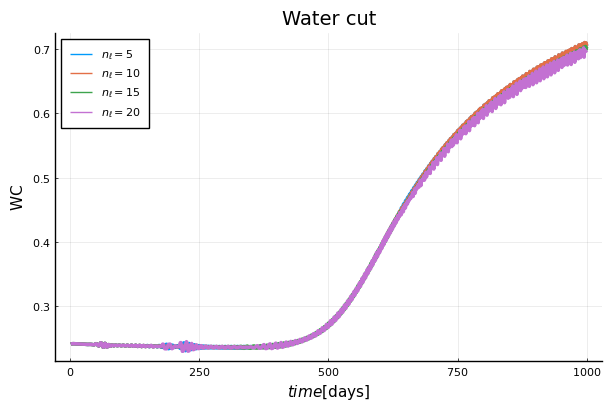

In [47]:
plot([1:tim],q_wcut_[5,:],lw=LW1,label = L"n_\ell=5",legend =:topleft,
    xlabel = L"time[\mathrm{days}]",
    ylabel = L"\mathrm{WC}", title = "Water cut")
plot!([1:tim],q_wcut_[10,:],
    lw=LW1, label = L"n_\ell=10")
plot!([1:tim],q_wcut_[15,:],
    lw=LW1, label = L"n_\ell=15")
plot!([1:tim],q_wcut_[20,:],
    lw=LW1, label = L"n_\ell=20")
figfile = "watercut_OpenValve_CF.svg"
savefig(figpath*figfile)

In [123]:
watercut_avg = zeros(Float64,tim,1)
for i in 1:tim
    watercut_avg[i] = mean(q_wcut_[:,i])
end

In [124]:
mean(watercut_avg[:])

0.38615754885518216

In [14]:
plot([2:tim],pb_[2:tim]/1e5,lw=LW1,
    xlabel = L"time[\mathrm{days}]",
    ylabel = L"P_\mathrm{\mathrm{bh}}[\mathrm{bar}]",legend = false, title = "Bottom hole pressure")
figfile = "BottomHolePressure_OpenValve_CF.svg"
savefig(figpath*figfile)

<!DOCTYPE html>
 
 
 Plots.jl

In [21]:
plot([1:tim],Saturation_average[1,:],
    lw=LW1, label = L"n_r=1",
    xlabel = L"time[\mathrm{days}]",
    ylabel = L"S_\mathrm{\mathrm{w}}",legend =:topleft, title = "Average water saturation")

plot!([1:tim],Saturation_average[5,:],
    lw=LW1, label = L"n_r=5")

plot!([1:tim],Saturation_average[10,:],
    lw=LW1, label = L"n_r=10")

plot!([1:tim],Saturation_average[15,:],
    lw=LW1, label = L"n_r=15")

plot!([1:tim],Saturation_average[20,:],
    lw=LW1, label = L"n_r= 20")
figfile = "AvgSaturation_OpenValve_CF.svg"
savefig(figpath*figfile)


<!DOCTYPE html>
 
 
 Plots.jl

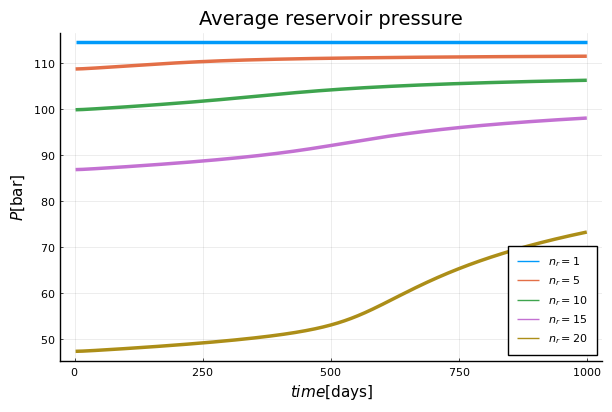

In [13]:
plot([2:tim],Press_average[1,2:end]./1e5,
    lw=LW1, label = L"n_r=1",
    xlabel = L"time[\mathrm{days}]",
    ylabel = L"P[\mathrm{bar}]",legend =:bottomright, title = "Average reservoir pressure")

plot!([2:tim],Press_average[5,2:end]./1e5,
    lw=LW1, label = L"n_r=5")

plot!([2:tim],Press_average[10,2:end]./1e5,
    lw=LW1, label = L"n_r=10")

plot!([2:tim],Press_average[15,2:end]./1e5,
    lw=LW1, label = L"n_r=15")

plot!([2:tim],Press_average[20,2:end]./1e5,
    lw=LW1, label = L"n_r= 20")
figfile = "Pressure_OpenValve_CF.svg"
savefig(figpath*figfile)

# Pressure profiles

In [19]:
plot([1:m],Press_i[:,5,400]./1e5,
    lw=LW1, label = L"n_\ell=5",
    xlabel = L"time[\mathrm{days}]",
    ylabel = L"P[\mathrm{bar}]",legend =:topright, title = "Pressure variation along the reservoir radius")
plot!([1:m],Press_i[:,10,400]./1e5,
    lw=LW1, label = L"n_\ell=10")

plot!([1:m],Press_i[:,15,400]./1e5,
    lw=LW1, label = L"n_\ell=15")

plot!([1:m],Press_i[:,20,400]./1e5,
    lw=LW1, label = L"n_\ell=20")

figfile = "Pressure_along_radius_OpenValve_CF.svg"
savefig(figpath*figfile)

<!DOCTYPE html>
 
 
 Plots.jl

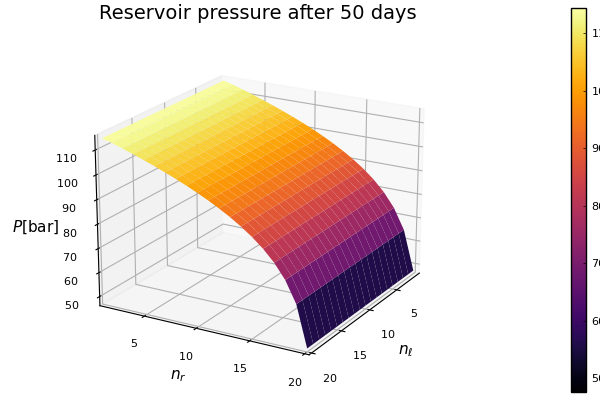

In [10]:
P50_openValve = surface(Press_i[:,:,50]./1e5,camera=(120,20),
    xlabel=L"n_\mathrm{\ell}",
    ylabel=L"n_r",
    zlabel=L"P[\mathrm{bar}]",
    title = "Reservoir pressure after 50 days")

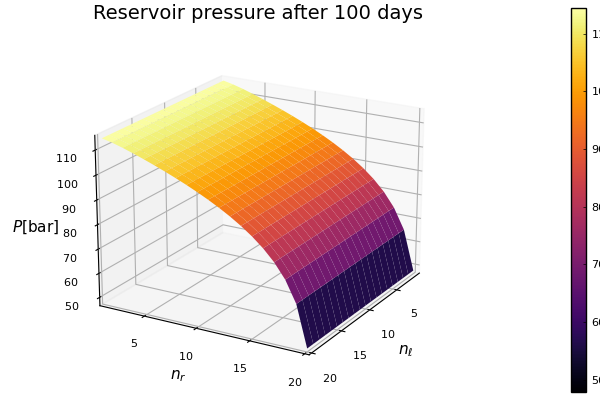

In [11]:
P100_openValve = surface(Press_i[:,:,100]./1e5,camera=(120,20),
    xlabel=L"n_\mathrm{\ell}",
    ylabel=L"n_r",
    zlabel=L"P[\mathrm{bar}]",
    title = "Reservoir pressure after 100 days")

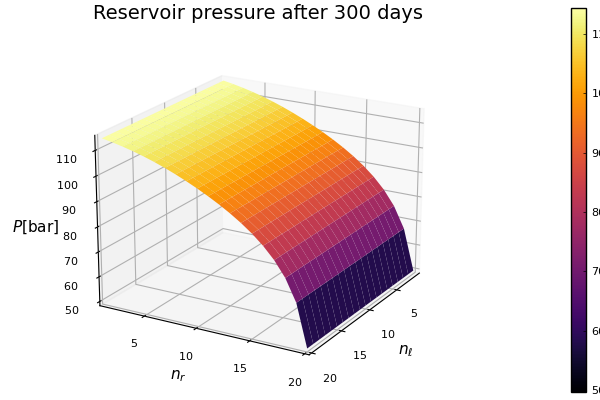

In [12]:
P300_openValve = surface(Press_i[:,:,300]./1e5,camera=(120,20),
    xlabel=L"n_\mathrm{\ell}",
    ylabel=L"n_r",
    zlabel=L"P[\mathrm{bar}]",
    title = "Reservoir pressure after 300 days")

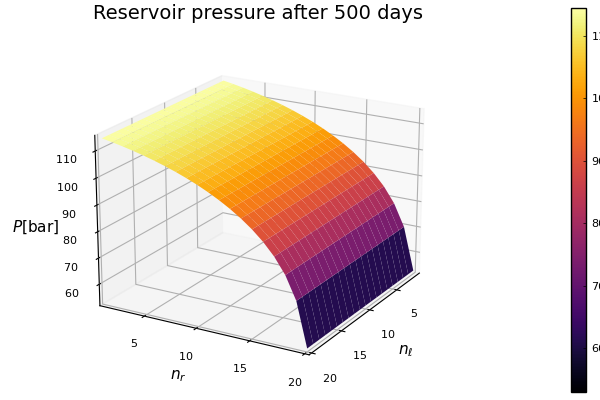

In [13]:
P500_openValve = surface(Press_i[:,:,500]./1e5,camera=(120,20),
    xlabel=L"n_\mathrm{\ell}",
    ylabel=L"n_r",
    zlabel=L"P[\mathrm{bar}]",
    title = "Reservoir pressure after 500 days")

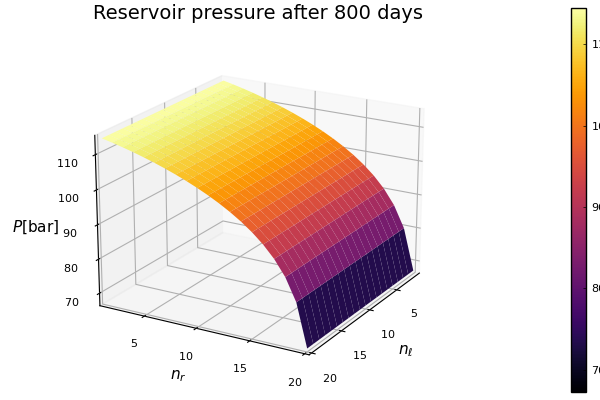

In [14]:
P800_openValve = surface(Press_i[:,:,800]./1e5,camera=(120,20),
    xlabel=L"n_\mathrm{\ell}",
    ylabel=L"n_r",
    zlabel=L"P[\mathrm{bar}]",
    title = "Reservoir pressure after 800 days")

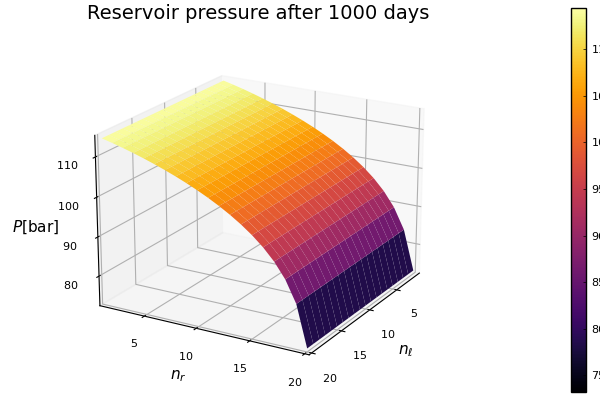

In [15]:
P1000_openValve = surface(Press_i[:,:,1000]./1e5,camera=(120,20),
    xlabel=L"n_\mathrm{\ell}",
    ylabel=L"n_r",
    zlabel=L"P[\mathrm{bar}]",
    title = "Reservoir pressure after 1000 days")

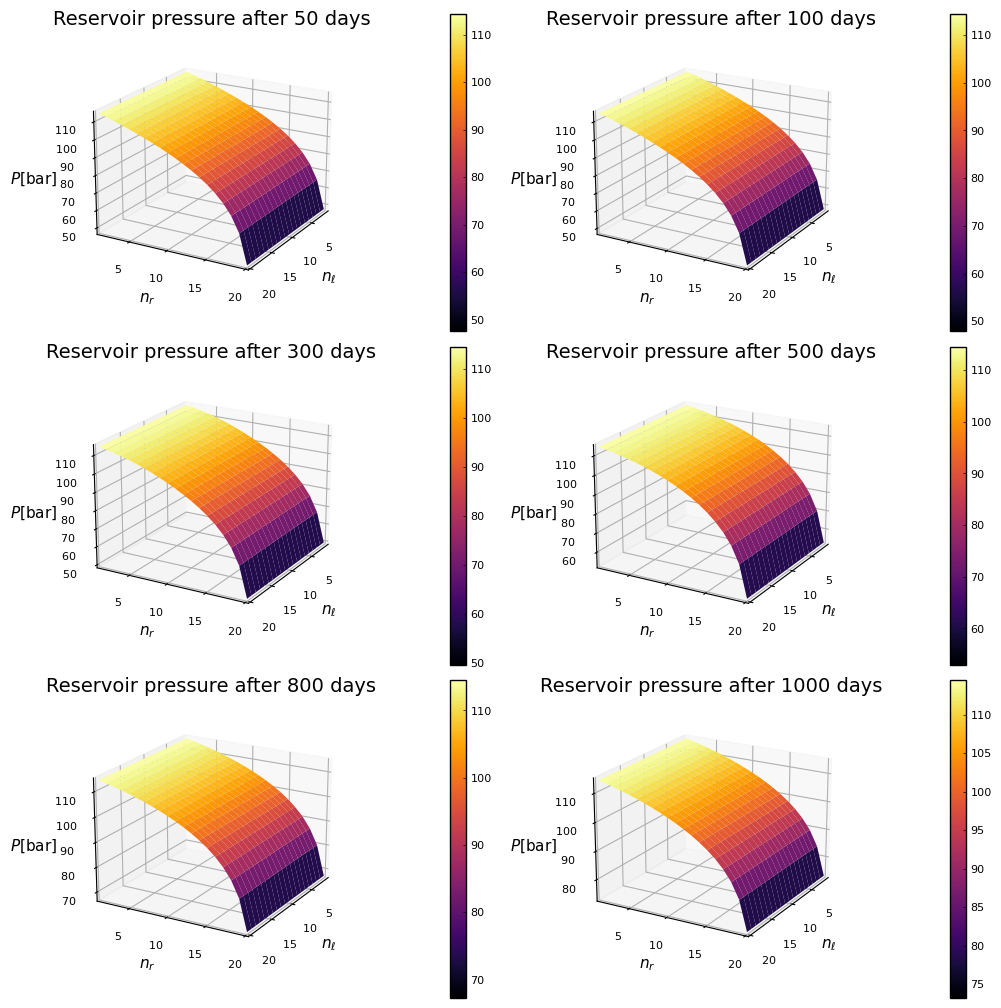

In [52]:
plot(P50_openValve,P100_openValve,P300_openValve,P500_openValve,P800_openValve,P1000_openValve,
        layout=grid(3,2),size = (1000, 1000),framestyle = :box,
        bottom_margin=10mm,right_margin=10mm)
figfile="CombinedPressure_OpenValve_CF.png"
savefig(figpath*figfile)

# Saturation profile

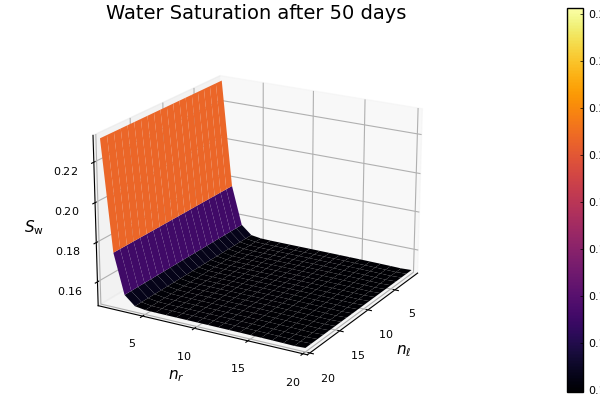

In [17]:
sw50_openValve = surface(sol(50),camera=(120,20),
    xlabel=L"n_\mathrm{\ell}",
    ylabel=L"n_r",
    zlabel=L"S_\mathrm{\mathrm{w}}",
    title = "Water Saturation after 50 days")

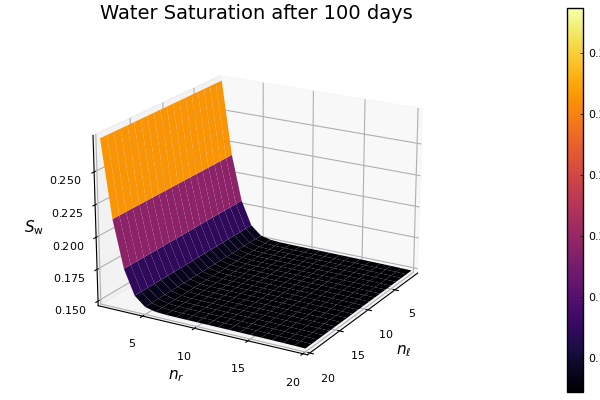

In [18]:
sw100_openValve = surface(sol(100),camera=(120,20),
    xlabel=L"n_\mathrm{\ell}",
    ylabel=L"n_r",
    zlabel=L"S_\mathrm{\mathrm{w}}",
    title = "Water Saturation after 100 days")

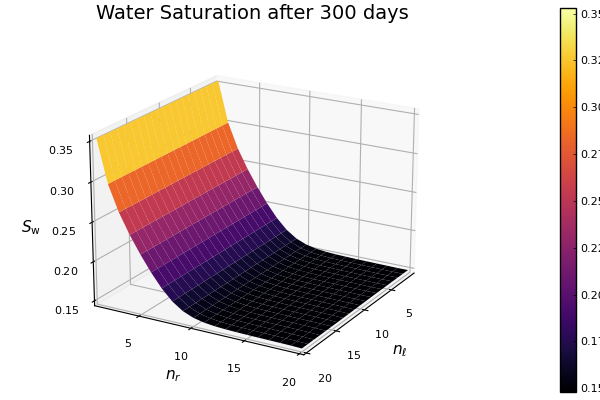

In [19]:
sw300_openValve = surface(sol(300),camera=(120,20),
    xlabel=L"n_\mathrm{\ell}",
    ylabel=L"n_r",
    zlabel=L"S_\mathrm{\mathrm{w}}",
    title = "Water Saturation after 300 days")

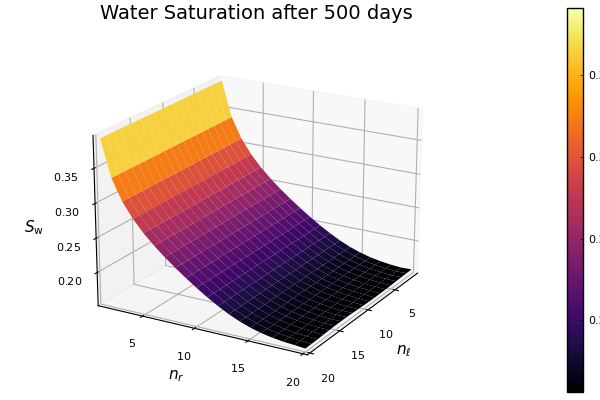

In [20]:
sw500_openValve = surface(sol(500),camera=(120,20),
    xlabel=L"n_\mathrm{\ell}",
    ylabel=L"n_r",
    zlabel=L"S_\mathrm{\mathrm{w}}",
    title = "Water Saturation after 500 days")

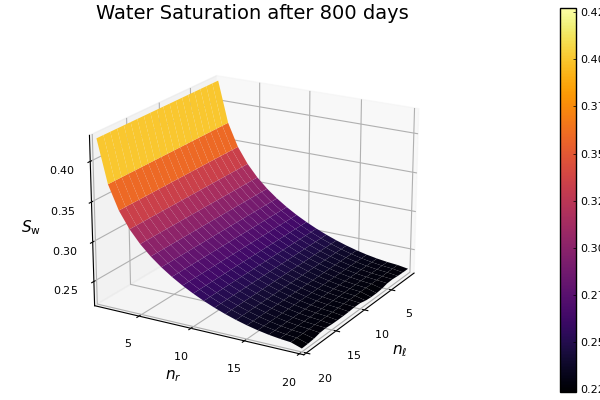

In [21]:
sw800_openValve = surface(sol(800),camera=(120,20),
    xlabel=L"n_\mathrm{\ell}",
    ylabel=L"n_r",
    zlabel=L"S_\mathrm{\mathrm{w}}",
    title = "Water Saturation after 800 days")

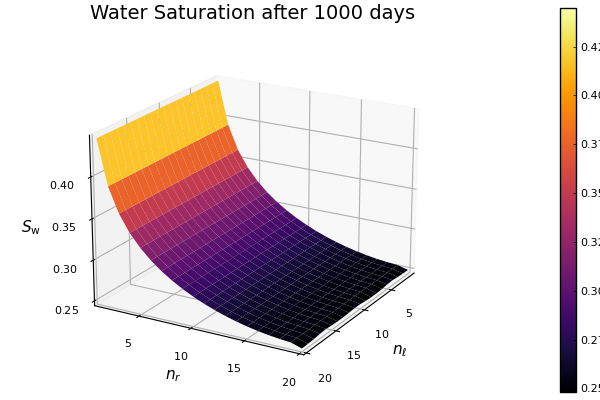

In [22]:
sw1000_openValve = surface(sol(1000),camera=(120,20),
    xlabel=L"n_\mathrm{\ell}",
    ylabel=L"n_r",
    zlabel=L"S_\mathrm{\mathrm{w}}",
    title = "Water Saturation after 1000 days")

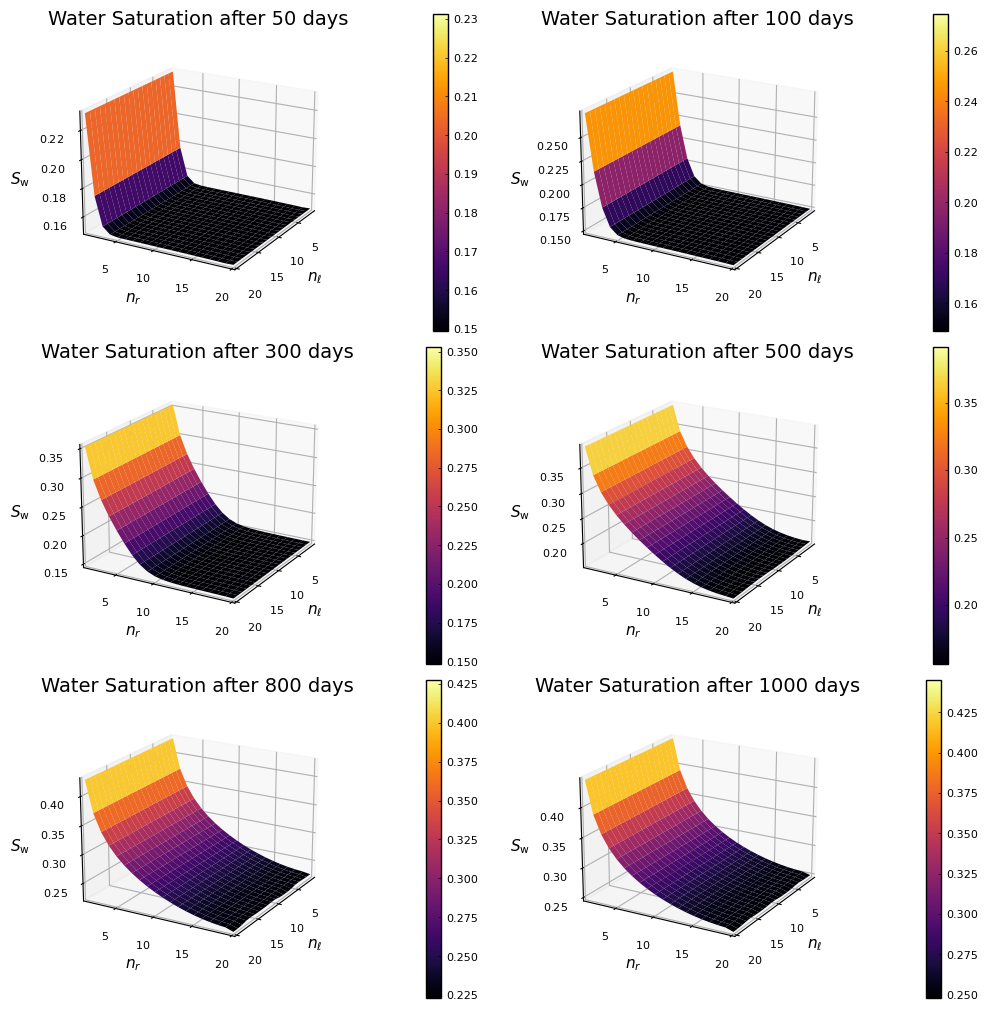

In [23]:
plot(sw50_openValve,sw100_openValve,sw300_openValve,sw500_openValve,sw800_openValve,sw1000_openValve,
        layout=grid(3,2),size = (1000, 1000),framestyle = :box,
        bottom_margin=10mm,right_margin=8mm,legend=:topleft)
figfile="CombinedSaturation_OpenValve_CF.svg"
savefig(figpath*figfile)

# Fluid flow rates

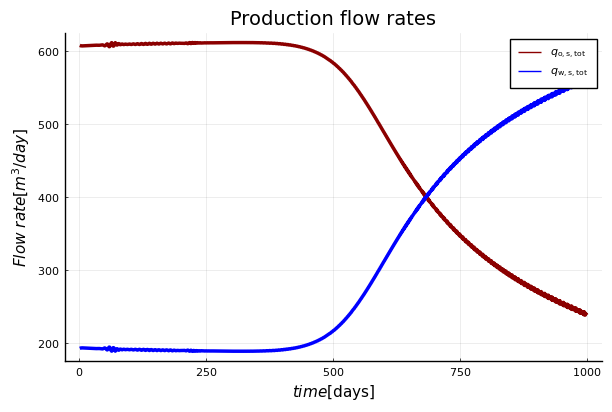

In [127]:
plot(summat_qo[1:tim]*3600*24, lc=LCoil,
    lw=LW1, label = L"q_\mathrm{o,s,tot}",
    xlabel = L"time[\mathrm{days}]",
    ylabel = L"Flow\ rate[m^3/day]",title = "Production flow rates")
plot!(summat_qw[1:tim]*3600*24, lc=LCwater,lw=LW1,label = L"q_\mathrm{w,s,tot}")
figfile="Flowrates_OpenValve_CF.svg"
savefig(figpath*figfile)

In [130]:
mean(summat_qo[1:tim]*3600*24)

491.0716317807162

In [131]:
mean(summat_qw[1:tim]*3600*24)

308.92476307536293

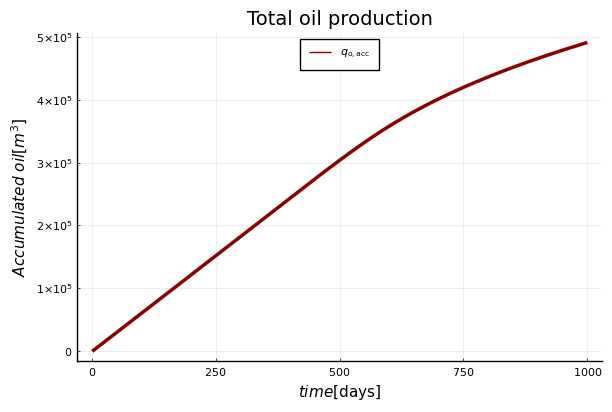

In [49]:
plot(Acc_qo[1:tim],lc=LCoil,lw=LW1,
    label = L"q_\mathrm{o,acc}",xlabel = L"time[\mathrm{days}]",
    ylabel = L"Accumulated\ oil[m^3]",legend = :top,title = "Total oil production")

figfile="AccumulatedOil_OpenValve_CF.svg"
savefig(figpath*figfile)

In [36]:
Acc_qo[1000]

490735.95850379777

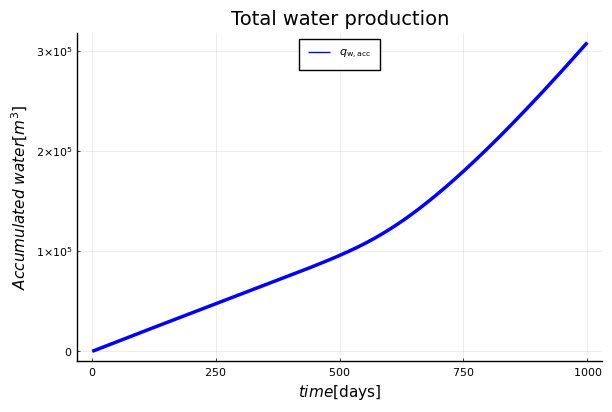

In [50]:
plot(Acc_qw[1:tim],lc=LCwater,lw=LW1,
    label = L"q_\mathrm{w,acc}",xlabel = L"time[\mathrm{days}]",
    ylabel = L"Accumulated\ water[m^3]",legend = :top,title = "Total water production")
figfile="AccumulatedWater_OpenValve_CF.svg"
savefig(figpath*figfile)